In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt

from graphviz import Digraph

%matplotlib inline

## Value object

In [74]:
class Value:
    def __init__(self, data, label='', op='', children=()):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(children)
        self._op = op
        self.label = label

    def __repr__(self):
        return f'Value({self.data})'

    def __add__(self, other):
        out = Value(self.data + other.data, children=(self, other), op='+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, children=(self, other), op='*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def  tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, children=(self,), op='tanh')

        def _backward():
            self.grad += (1- t**2) * out.grad

        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def topsort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topsort(child)
                topo.append(v)
        topsort(self)

        # set grad to 1.0 or everything will be zero
        self.grad = 1.0
        # start at the current node
        for node in reversed(topo):
            node._backward()
    
    def dot(self):
        dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
        
        # builds a set of all nodes and edges in a graph
        nodes, edges = set(), set()
        def build(v):
          if v not in nodes:
            nodes.add(v)
            for child in v._prev:
              edges.add((child, v))
              build(child)
        build(self)

        for n in nodes:
          uid = str(id(n))
          # for any value in the graph, create a rectangular ('record') node for it
          dot.node(name = uid, label = "{ %s | %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
          if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
        for n1, n2 in edges:
          # connect n1 to the op node of n2
          dot.edge(str(id(n1)), str(id(n2)) + n2._op)
            
        return dot

In [32]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(-8.0)

Suppose `L` is a loss function.

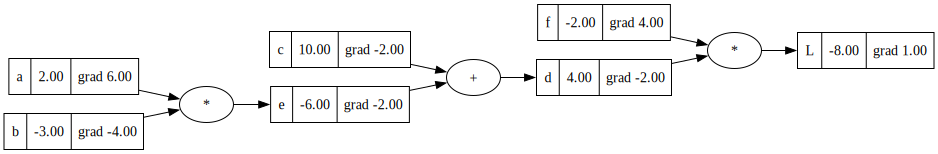

In [21]:
L.dot()

In [20]:
L.grad = 1.0; 
d.grad = -2.0; # dL/dd = d * f = f
f.grad = 4.0; # dL/df = d * f = d
c.grad = -2.0;
e.grad = -2.0;
a.grad = (-2.0 * -3.0);
b.grad = (-2.0 * 2.0);

## Manual backpropagation

In [24]:
def lol():
    h = .001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

0.0


## Chain rule

Backpropagation is recursive application of chain rule.

### Plus node

dd / dc = 1.0
dd / de = 1.0

d = c + e # plus node derivative are just 1.0

We want:
dL / dc = (dL / dd) * (dd / dc)

We know:
dL / dd
dd / dc


e = a * b
de / da = b
de / db = a

We know:
dL / de = -2.0

We want:
dL / da = (dL/de) * (de/da)

## Manual backpropagation 2

In [35]:

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

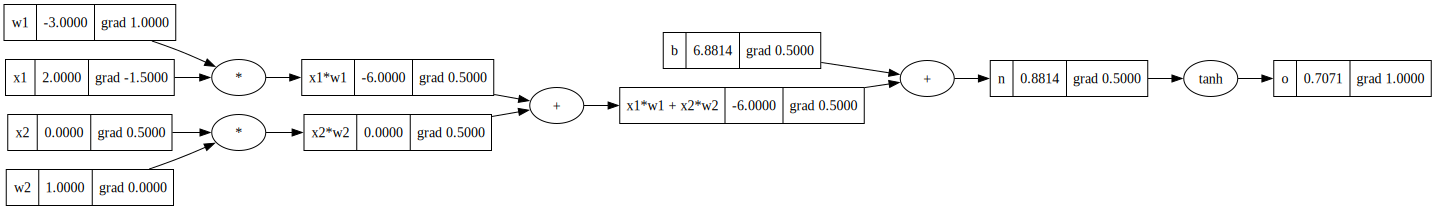

In [52]:
o.dot()

In [42]:
# o = tanh(n)
# do/dn = 1- tanh(n)^2
print(1-o.data**2)

0.4999999999999999


In [51]:
x2.grad = w2.data * x2w2.grad;
w2.grad = x2.data * x2w2.grad;

x1.grad = w1.data * x1w1.grad;
w1.grad = x1.data * x1w1.grad;

x1w1.grad = .5;
x2w2.grad = .5;

x1w1x2w2.grad = .5;
b.grad = .5;

n.grad = .5;

o.grad = 1.0;

## Automatic backpropagation

In [75]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

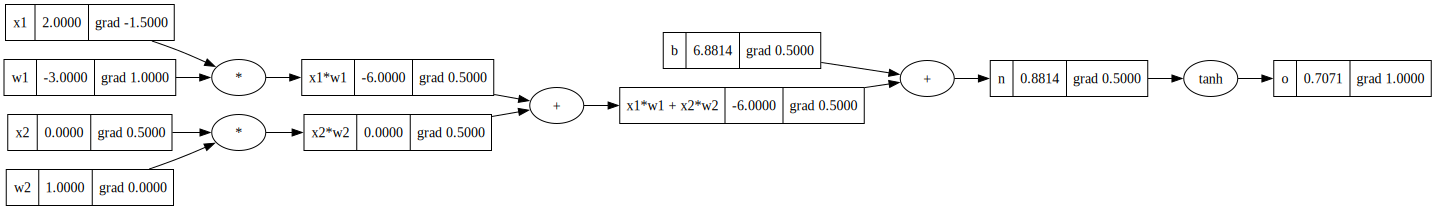

In [78]:
o.dot()

In [77]:
o.backward()

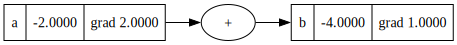

In [79]:
a = Value(-2.0, label='a')
b = a + a; b.label = 'b';
b.backward()
b.dot()